<h1 style="text-align: center;">Simulación y aplicaciones en ciencias sociales y experimentales
</h3>
<h3 style="text-align: center;"> Tema 2.2 Modelos deterministas de segundo orden </h3>
<h3 style="text-align: center;"> Ejercicios propuestos </h3>

### Ejercicio 1

El siguiente modelo propone representar el proceso de regulación de la glucosa en sangre a través de la producción de insulina. Para ello seguiremos el denominado **modelo mínimo** (más detalles en [Bergman et al, 2006](https://journals.physiology.org/doi/abs/10.1152/ajpendo.1979.236.6.E667), modelo VI), que asume dos hipótesis:

1. La glucosa, una vez introducida en sangre, vuelve a sus niveles basales debido a dos efectos: reducción natural de la concentración de glucosa y el efecto de la insulina.
2. La insulina no actúa directamente, sino que primero se desplaza de la sangre al fluido que rodea al tejido celular y de ahí actúa sobre la glucosa.

El modelo mínimo consiste en dos ecuaciones diferenciales:

$$\begin{array}{l}\displaystyle{\dot{G}} = -k_1 \left[ G(t) - G_b \right] - X(t) G(t),\\
\displaystyle{\dot{X}} = k_3 \left[I(t) - I_b \right] - k_2 X(t),\end{array}$$ 

donde $G$ y $X$ son las concentraciones de glucosa en sangre y de insulina en el fluido del tejido celular, respectivamente. La función $I(t)$ indica la concentración de insulina en sangre, que tomamos exógena. Los parámetros $G_b$ e $I_b$ son los niveles basales de glucosa e insulina en sangre, mientras que $k_1$, $k_2$ y $k_3$ son parámetros positivos que controlan las tasas de decaemiento de glucosa e insulina. Los datos que se encuentran en este [archivo](https://github.com/AllenDowney/ModSim/raw/main/data/glucose\_insulin.csv) indican la concentración en sangre de glucosa e insulina medidos durante 182 minutos a un paciente normal.

**(a)** Estimar la concentración de glucosa en sangre a través del modelo.  En la simulación tomar como datos iniciales $k_1 = 0.02$,  $k_2 = 0.02$, $k_3 = 1.5e-05$, y unos niveles iniciales $G_0=270$ y $X_0=0$. Los niveles basales de glucosa e insulina en sangre son los iniciales de los datos reales. En la simulación es necesario interpolar los datos reales de concentración de insulina para cada minuto.

**(b)** Hallar los valores de los parámetros $k_1$, $k_2$ y $k_3$ con los que se obtenga el mejor ajuste de la simulación de la concentración de glucosa en sangre a los datos reales. Para el ajuste tomar los datos a partir de la cuarta toma de glucosa.

**(c)** Realmente la producción de insulina es endógena al sistema, y se propone que sigue la siguiente ecuación: 

$$ \dot{I} = -k I + \gamma (G - G_T) t, $$

siendo $k$, $\gamma$ y $G_T$ parámetros del modelo. Obsérvese que el incremento del la insulina depende del tiempo, indicando una sensibilidad creciente de la glucosa en la producción de insulina con el tiempo. Simular el nuevo modelo con valores iniciales de $k = 0.25$, $\gamma = 0.004$ y $G_T = 80$, con unos niveles de insulina iniciales de $I_0=360$. Ajustar estos parámetros de forma que se represente lo mejor posible los datos reales a partir de la cuarta toma.     

**(d)** Existen dos medidas biológicas que se construyen a partir de los parámetros del modelo:

$$ \begin{array}{l}\phi_1 = \frac{I_{max} - I_b}{k (G_0 - G_b)},\\
    \phi_2 = \gamma \times 10^4.\end{array} $$
   
Según algunos autores, los valores esperados de estos parámetros están entre 2 y 4 para $\phi_1$ y 20 y 35 para $\phi_2$. Comprobar si con el ajuste realizado los valores de estas medidas están en los rangos esperados.  


A)

In [18]:
import pandas as pd

file_path = 'glucose_insulin.csv'
data = pd.read_csv(file_path)

time = data['time'].values  # Tiempo en minutos
insulin_data = data['insulin'].values  # Concentración de insulina en sangre
glucose_data = data['glucose'].values  # Concentración de glucosa en sangre


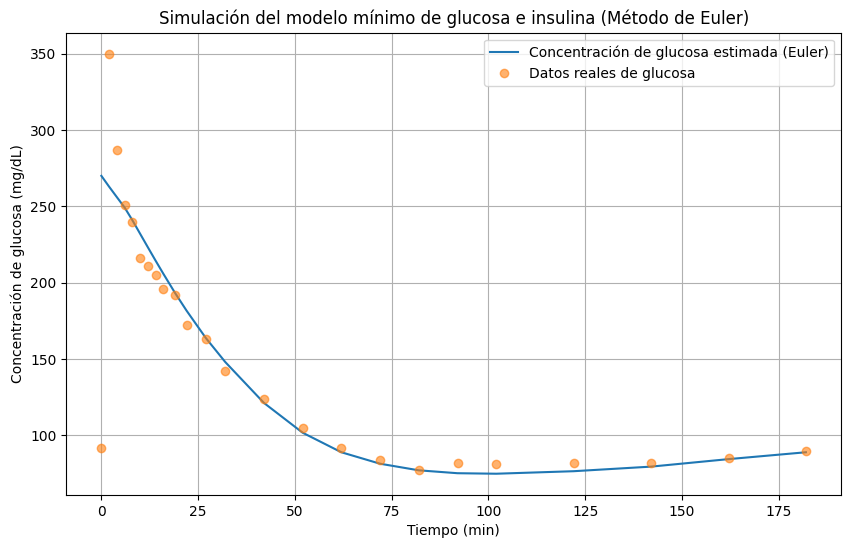

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Definir las constantes dadas nuevamente
k1 = 0.02
k2 = 0.02
k3 = 1.5e-5
Gb = glucose_data[0] # Nivel basal de glucosa
Ib = insulin_data[0]  # Nivel basal de insulina

# Condiciones iniciales
G0 = 270  # Concentración inicial de glucosa
X0 = 0    # Concentración inicial de insulina en el fluido extracelular

# Definir la función de Euler para resolver las ODEs
def solveODE_euler(f, x0, t, D, arg=()):
    n = len(t)
    x = np.zeros((n, len(x0)))
    x[0] = x0
    for i in range(n - 1):
        # Interpolar la concentración de insulina para cada minuto
        I = np.interp(t[i], time, D)
        x[i+1] = x[i] + (t[i+1] - t[i]) * f(x[i], t[i], I, *arg)
    return x

# Definir la función que representa el sistema de ecuaciones diferenciales
def sys(y, t, I, k1, k2, k3, Gb, Ib):
    G, X = y
    dGdt = -k1 * (G - Gb) - X * G
    dXdt = k3 * (I - Ib) - k2 * X
    return np.array([dGdt, dXdt])

# Condiciones iniciales y constantes
y0 = [G0, X0]

# Resolver las ecuaciones utilizando el método de Euler
solution_euler = solveODE_euler(sys, y0, time, insulin_data, (k1, k2, k3, Gb, Ib))

# Extraer la solución de la glucosa
G_solution_euler = solution_euler[:, 0]

# Graficar los resultados
plt.figure(figsize=(10,6))
plt.plot(time, G_solution_euler, label='Concentración de glucosa estimada (Euler)')
plt.plot(time, glucose_data, 'o', label='Datos reales de glucosa', alpha=0.6)
plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración de glucosa (mg/dL)')
plt.title('Simulación del modelo mínimo de glucosa e insulina (Método de Euler)')
plt.legend()
plt.grid(True)
plt.show()

B)

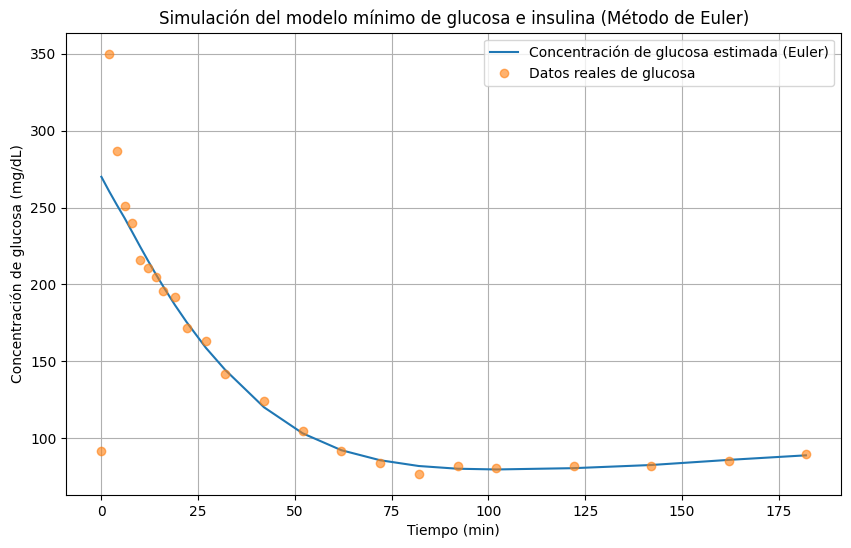

In [20]:
# APARTADO B)

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Definir las constantes dadas nuevamente
k1 = 0.02
k2 = 0.02
k3 = 1.5e-5
Gb = glucose_data[0] # Nivel basal de glucosa
Ib = insulin_data[0]  # Nivel basal de insulina

# Condiciones iniciales
G0 = 270  # Concentración inicial de glucosa
X0 = 0    # Concentración inicial de insulina en el fluido extracelular

# Definir la función de Euler para resolver las ODEs
def solveODE_euler(f, x0, t, D, arg=()):
    n = len(t)
    x = np.zeros((n, len(x0)))
    x[0] = x0
    for i in range(n - 1):
        # Interpolar la concentración de insulina para cada minuto
        I = np.interp(t[i], time, D)
        x[i+1] = x[i] + (t[i+1] - t[i]) * f(x[i], t[i], I, *arg)
    return x

# Definir la función que representa el sistema de ecuaciones diferenciales
def sys(y, t, I, k1, k2, k3, Gb, Ib):
    G, X = y
    dGdt = -k1 * (G - Gb) - X * G
    dXdt = k3 * (I - Ib) - k2 * X
    return np.array([dGdt, dXdt])

# Definir la función de costo para el ajuste de parámetros
def cost_function(params):
    k1, k2, k3 = params
    y0 = [G0, X0]
    solution_euler = solveODE_euler(sys, y0, time, insulin_data, (k1, k2, k3, Gb, Ib))
    G_solution_euler = solution_euler[:, 0]
    return np.sum((G_solution_euler[3:] - glucose_data[3:]) ** 2)

# Definir los valores iniciales de los parámetros
initial_params = [k1, k2, k3]

# Realizar la optimización para encontrar los mejores valores de los parámetros
result = minimize(cost_function, initial_params, method='Nelder-Mead')

# Obtener los mejores valores de los parámetros
best_params = result.x
k1_best, k2_best, k3_best = best_params

# Condiciones iniciales y constantes
y0 = [G0, X0]

# Resolver las ecuaciones utilizando el método de Euler
solution_euler = solveODE_euler(sys, y0, time, insulin_data, (k1_best, k2_best, k3_best, Gb, Ib))

# Extraer la solución de la glucosa
G_solution_euler = solution_euler[:, 0]

# Graficar los resultados
plt.figure(figsize=(10,6))
plt.plot(time, G_solution_euler, label='Concentración de glucosa estimada (Euler)')
plt.plot(time, glucose_data, 'o', label='Datos reales de glucosa', alpha=0.6)
plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración de glucosa (mg/dL)')
plt.title('Simulación del modelo mínimo de glucosa e insulina (Método de Euler)')
plt.legend()
plt.grid(True)
plt.show()

C)

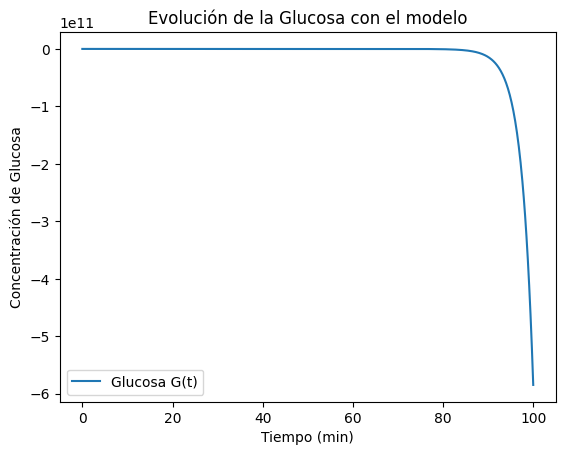

In [4]:
k = 0.25
Gt = 80
sigma = 0.004
I0 = 360
y = 270

def sys(t, y, k, Gt, sigma, I0):
    G = y
    dGdt = -k * I0 + sigma * (G - Gt)*t
    return dGdt

def solveODE_euler(f, x0, t, args=()):
    n = len(t)
    x = np.zeros(n)  # Almacenar todas las soluciones
    x[0] = x0  # Condiciones iniciales
    for i in range(n - 1):
        x[i+1] = x[i] + (t[i+1] - t[i]) * f(t[i], x[i], *args)  # Aproximación por Euler
    return x

t = np.linspace(0, 100, 1000)

sol = solveODE_euler(sys, y, t, args=(k, Gt, sigma, I0))

plt.plot(t, sol, label='Glucosa G(t)')
plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración de Glucosa')
plt.title('Evolución de la Glucosa con el modelo')
plt.legend()


### Ejercicio 2

El oscilador de Van der Pol es un sistema dinámico creado alrededor de 1926 que consiste en un circuito eléctrico con realimentaciones positivas y resistores no lineales. El circuito, tal como se diseñó, favorece oscilaciones pequeñas y amortigua las grandes. Una extensión de estos sistemas se ha aplicado en Medicina para simular el proceso de un marcapasos. Un interesante resumen de la historia y análisis matemático del oscilador de Van der Pol lo pueden encontrar en el trabajo de [Casaico-Suárez et al. (1920)](https://www.researchgate.net/publication/344507421_El_Oscilador_de_Van_Der_Pol).

Aplicando las leyes físicas al circuito eléctrico de Van der Pol, se llega a la siguiente ecuación: 

$$\ddot{x} -\mu (1-x^2) \dot{x} +x =0,$$

donde $x$ es una combinación de las variables eléctricas del sistema (intensidad, voltaje, etc.) y $\mu$ es un parámetro de control de la resistencia. 

**a)** Simular el sistema de orden 2 para las condiciones iniciales $x(0)=0.5$, $\dot{x}(0)=0.5$ y $\mu=1$. Para ello escribir el modelo como un sistema de ecuaciones diferenciales de dos variables $x$ e $y$, con $y= \dot{x}$. Realizar la gráfica de la trayectoria de la variable $x$ y el diagrama de fases $(x,y)$. 

**b)** Hallar los puntos de equilibrio del sistema y los valores propios del sistema en función de $\mu$. Determinar valores de $\mu$ donde los valores propios cambian de signo y/o la parte imaginaria del valor propio pasa de nula a no nula o viceversa. 

**c)** Simular el modelo para valores de $\mu$ dentro de los diversos rangos definidos por los valores calculados en el apartado **b)**. Tomar distintas condiciones iniciales. 

### Ejercicio 3

En 1963, el meteorólogo E. Lorenz propuso un modelo que representa la convección de un fluido en los lados de columnas hexagonales. Las ecuaciones del modelo son las siguientes: 

$$ \begin{array}{l} \dot{x} = \sigma (y-z), \\ \dot{y} = rx -y-xz, \\ \dot{z} = xy-bz, \end{array}$$

donde $x$ mide la tasa de vuelco convectivo, $y$ la variación de temperatura horizontal y $z$ la variación de temperatura vertical.Los parámetros $\sigma$, $r$ y $b$ representan constantes relacionadas con la viscosidad del fluido y diferencias de temperatura. 

El modelo representa de forma muy simplificada el sistema del clima. Por tanto, la complejidad de las soluciones de este modelo ilustra la tremenda complejidad del clima real. Más detalles en [Lorenz (1963)](https://journals.ametsoc.org/view/journals/atsc/20/2/1520-0469_1963_020_0130_dnf_2_0_co_2.xml)

**(a)** Simular el modelo y representar las trayectorias de $x(t)$ y el diagrama de fases tridimensional $(x,y,z)$. Tomar como condición inicial $x(0) = 10$, $y(0) = z(0) = 5$, y valores de los parámetros $\sigma=10$, $b=8/3$. Tomar valores de $r$ en el conjunto $\{5, 12, 20, 28\}$. Determinar con la simulación el comportamiento asintótico de las variables. 

**(b)** Comprobar la sensibilidad de los resultados del modelo a las condiciones iniciales en los tres primeros valores de $r$ (5, 12, 20). Esto es, dado $x_\epsilon$ las solución del modelo con $x_\epsilon(0)=x(0)+\epsilon$ y $T$ un tiempo suficientemente alto, se trata de estudiar la diferencia $x(T)-x_\epsilon(T)$ en función de $\epsilon$. Debe converger a cero para $\epsilon \rightarrow 0$.

**(c)** La figura observada en el diagrama de fases en el caso $r=28$ se denomina 'Atractor de Lorenz'. Es una figura en general estable para valores de $r>25$ (comprobar). Comprobar la sensibilidad del modelo a las condiciones iniciales para $r=28$ (o cualquier otro que presente el atractor de Lorenz).  

A)

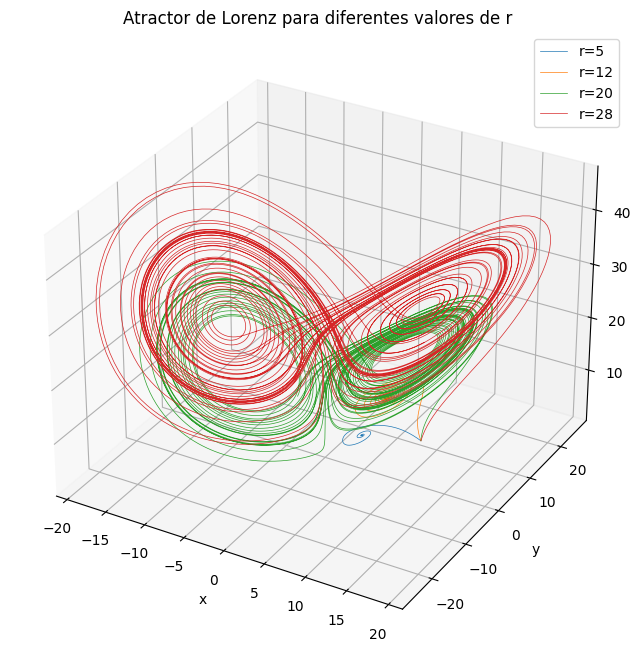

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parámetros
sigma = 10
b = 8/3
r = [5, 12, 20, 28]
initial_state = [10, 5, 5]  # x(0), y(0), z(0)

# Sistema de Lorenz
def sys(t, state, sigma, r, b):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = r * x - y - x * z
    dzdt = x * y - b * z
    return [dxdt, dydt, dzdt]

# Método de Euler modificado para manejar sistemas de ecuaciones
def solveODE_euler(f, x0, t, args=()):
    n = len(t)
    dim = len(x0)
    x = np.zeros((n, dim))  # Matriz para almacenar las soluciones (n x 3)
    x[0] = x0  # Condiciones iniciales
    for i in range(n - 1):
        dxdt = f(t[i], x[i], *args)  # Derivadas
        x[i+1] = x[i] + (t[i+1] - t[i]) * np.array(dxdt)  # Aproximación por Euler
    return x

# Intervalo de tiempo y puntos de evaluación
t_span = [0, 50]  # Tiempo
t_eval = np.linspace(t_span[0], t_span[1], 10000)  # Tiempo evaluado

# Crear una figura y un conjunto de ejes 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Simulación para diferentes valores de r
for r_value in r:
    sol = solveODE_euler(sys, initial_state, t_eval, args=(sigma, r_value, b))
    ax.plot(sol[:, 0], sol[:, 1], sol[:, 2], label=f'r={r_value}', lw=0.5)

# Personalizar el gráfico
ax.set_title('Atractor de Lorenz para diferentes valores de r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()

# Mostrar el gráfico
plt.show()


B)

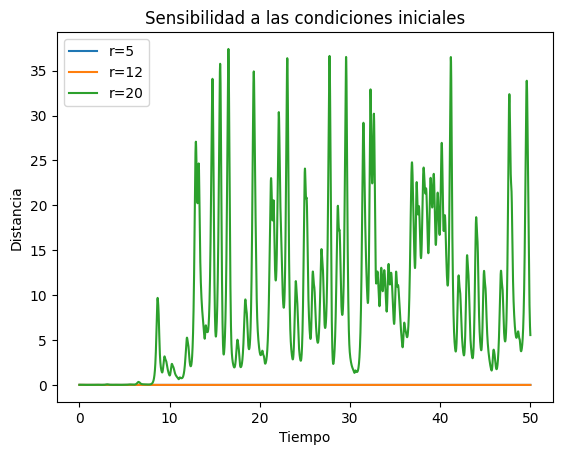

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
sigma = 10
b = 8/3
r = [5, 12, 20]
initial_state = [10, 5, 5]  # x(0), y(0), z(0)

# Sistema de Lorenz
def sys(t, state, sigma, r, b):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = r * x - y - x * z
    dzdt = x * y - b * z
    return [dxdt, dydt, dzdt]

# Método de Euler modificado para manejar sistemas de ecuaciones
def solveODE_euler(f, x0, t, args=()):
    n = len(t)
    dim = len(x0)
    x = np.zeros((n, dim))  # Matriz para almacenar las soluciones (n x 3)
    x[0] = x0  # Condiciones iniciales
    for i in range(n - 1):
        dxdt = f(t[i], x[i], *args)  # Derivadas
        x[i+1] = x[i] + (t[i+1] - t[i]) * np.array(dxdt)  # Aproximación por Euler
    return x

# Intervalo de tiempo y puntos de evaluación
t_span = 50  # Tiempo
t_eval = np.linspace(0, t_span, 10000)  # Tiempo evaluado
epsilon = 0.01 # Perturbación en las condiciones iniciales

# Simulación para diferentes valores de r
for r_value in r:
    sol = solveODE_euler(sys, initial_state, t_eval, args=(sigma, r_value, b))

    # Solución con condiciones iniciales perturbadas en x(0) + epsilon
    perturbed_state = [initial_state[0] + epsilon, initial_state[1], initial_state[2]]
    sol_perturbed = solveODE_euler(sys, perturbed_state, t_eval, args=(sigma, r_value, b))

    # Distancia euclidiana entre las soluciones
    distance = np.linalg.norm(sol - sol_perturbed, axis=1)
    plt.plot(t_eval, distance, label=f'r={r_value}')  # Distancia vs tiempo

plt.xlabel('Tiempo')
plt.ylabel('Distancia')
plt.title('Sensibilidad a las condiciones iniciales')
plt.legend()
plt.show()


En el gráfico, se puede observar cómo la diferencia entre las trayectorias $x(T)$ y $xϵ(T)$ varía en función del tiempo para los tres valores de $r$ (5, 12, 20). Los resultados muestran que:

Para $r=5$ y $r=12$, la diferencia entre las trayectorias permanece cercana a cero, indicando que el sistema no es particularmente sensible a pequeñas perturbaciones en las condiciones iniciales.

Para $r=20$, la diferencia crece rápidamente y se vuelve oscilatoria, lo que indica un comportamiento mucho más caótico y una alta sensibilidad a las condiciones iniciales.

Este comportamiento es característico de sistemas caóticos como el de Lorenz, donde pequeños cambios en las condiciones iniciales pueden llevar a trayectorias completamente diferentes con el tiempo, especialmente para valores de $r$ que generan dinámica caótica, como $r=20$.

C)

Utiliazamos el mismo código que en el apartado A) pero esta vez usando valores de $r$ mayores a 25 para comprobar su estabilidad.

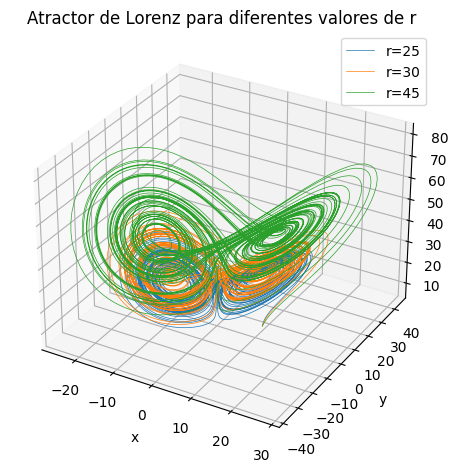

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parámetros
sigma = 10
b = 8/3
r = [25, 30, 45]
initial_state = [10, 5, 5]  # x(0), y(0), z(0)

# Sistema de Lorenz
def sys(t, state, sigma, r, b):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = r * x - y - x * z
    dzdt = x * y - b * z
    return [dxdt, dydt, dzdt]

# Método de Euler modificado para manejar sistemas de ecuaciones
def solveODE_euler(f, x0, t, args=()):
    n = len(t)
    dim = len(x0)
    x = np.zeros((n, dim))  # Matriz para almacenar las soluciones (n x 3)
    x[0] = x0  # Condiciones iniciales
    for i in range(n - 1):
        dxdt = f(t[i], x[i], *args)  # Derivadas
        x[i+1] = x[i] + (t[i+1] - t[i]) * np.array(dxdt)  # Aproximación por Euler
    return x

# Intervalo de tiempo y puntos de evaluación
t_span = [0, 50]  # Tiempo
t_eval = np.linspace(t_span[0], t_span[1], 10000)  # Tiempo evaluado

# Graficar el atractor de Lorenz (trayectoria original)
fig = plt.figure(figsize=(12, 6))

# Diagrama de fases tridimensional (Atractor de Lorenz)
ax = fig.add_subplot(121, projection='3d')

# Simulación para diferentes valores de r
for r_value in r:
    sol = solveODE_euler(sys, initial_state, t_eval, args=(sigma, r_value, b))
    ax.plot(sol[:, 0], sol[:, 1], sol[:, 2], label=f'r={r_value}', lw=0.5)

# Personalizar el gráfico
ax.set_title('Atractor de Lorenz para diferentes valores de r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()

# Mostrar el gráfico
plt.show()


A continuación, simulamos el modelo para $r=28$ y comprobamos la sensibilidad del modelo a las condiciones iniciales.

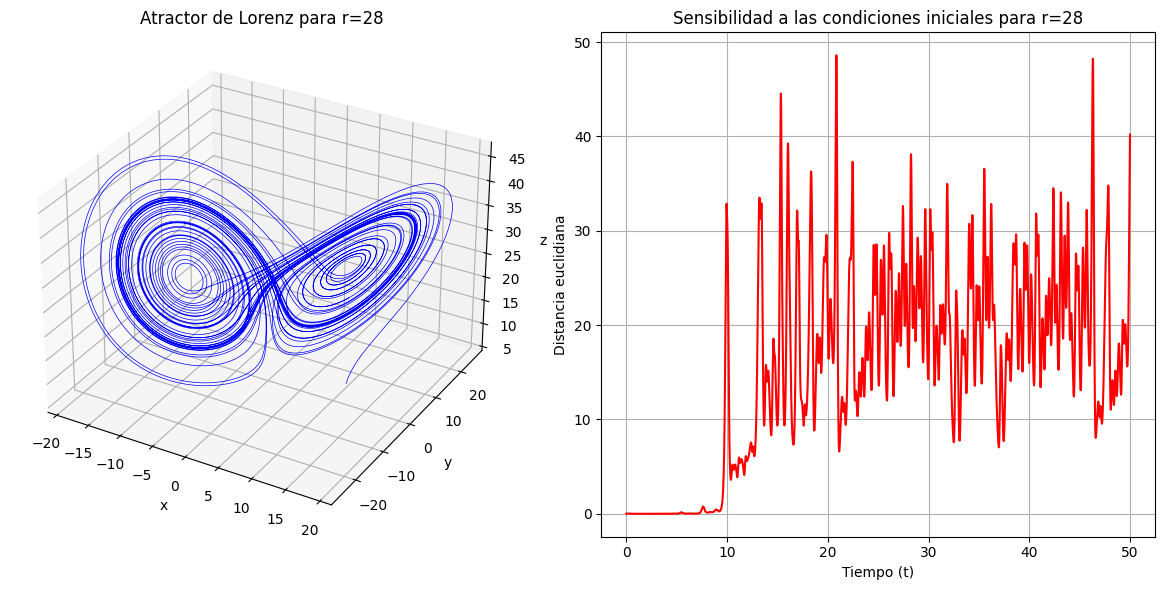

In [5]:
from mpl_toolkits.mplot3d import Axes3D

# Parámetros para r = 28
sigma = 10
b = 8/3
r = 28
initial_state = [10, 5, 5]  # x(0), y(0), z(0)
epsilon = 0.01  # Perturbación inicial
T = 50  # Tiempo máximo de simulación
t_eval = np.linspace(0, T, 10000)  # Tiempo evaluado

# Solución con condiciones iniciales originales
sol_original = solveODE_euler(sys, initial_state, t_eval, args=(sigma, r, b))

# Solución con condiciones iniciales perturbadas en x(0) + epsilon
perturbed_state = [initial_state[0] + epsilon, initial_state[1], initial_state[2]]
sol_perturbed = solveODE_euler(sys, perturbed_state, t_eval, args=(sigma, r, b))

# Calcular la distancia euclidiana entre las soluciones en todas las coordenadas
distance = np.linalg.norm(sol_original - sol_perturbed, axis=1)

# Graficar el atractor de Lorenz (trayectoria original)
fig = plt.figure(figsize=(12, 6))

# Diagrama de fases tridimensional (Atractor de Lorenz)
ax = fig.add_subplot(121, projection='3d')
ax.plot(sol_original[:, 0], sol_original[:, 1], sol_original[:, 2], color='b', lw=0.5)
ax.set_title('Atractor de Lorenz para r=28')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# Graficar la distancia euclidiana entre las trayectorias
plt.subplot(122)
plt.plot(t_eval, distance, color='r')
plt.xlabel('Tiempo (t)')
plt.ylabel('Distancia euclidiana')
plt.title('Sensibilidad a las condiciones iniciales para r=28')
plt.grid(True)

plt.tight_layout()
plt.show()


Para $r=28$, observamos el clásico Atractor de Lorenz, una figura compleja y caótica. Es estable en el sentido de que el sistema siempre termina acercándose a esta figura en el espacio de fases, pero las trayectorias son caóticas dentro de esta región.

El gráfico de la derecha muestra cómo la distancia euclidiana entre las trayectorias perturbadas y las trayectorias originales evoluciona con el tiempo. Como se puede ver, pequeñas diferencias en las condiciones iniciales ($ϵ=0.01$) resultan en grandes diferencias en las trayectorias a medida que el tiempo avanza, lo que es un signo claro de la naturaleza caótica del sistema.